<a href="https://colab.research.google.com/github/ziatdinovmax/notebooks_for_medium/blob/main/shiftVAE_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shift-VAE: Application to 1D spectra with arbitrary offset in peak position

Prepared by Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

Install pyroVED package:

In [1]:
!pip install -q pyroved

     |████████████████████████████████| 634kB 21.5MB/s 


Imports:

In [2]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import decomposition

First, we prepare our synthetic data representing 1D Gaussian signals with different widths that is randomly shifted along the *x*-axis and is corrupted by noise. In other words, in this example we assume that the only physical factor of variation is a signal width and other forms of variations are considered to be "instrumental distortion".

In [3]:
def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

n_samples = 5000 # number of samples
l_signal = 100 # signal length

# Generate synthetic dataset with randomly shifted noisy 1D signal
torch.manual_seed(1)  # for reproducibility
x = torch.linspace(-12, 12, l_signal).expand(n_samples, l_signal)
noise = torch.randint(1, 100, (n_samples, 1)) / 1e3
mu = torch.randint(-30, 30, size=(n_samples, 1)) / 10
sig = torch.randint(50, 500, size=(n_samples, 1)) / 1e2
train_data = gaussian(x, mu, sig) + noise * torch.randn(size=(n_samples, l_signal))
# Normalize to (0, 1)
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())

# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

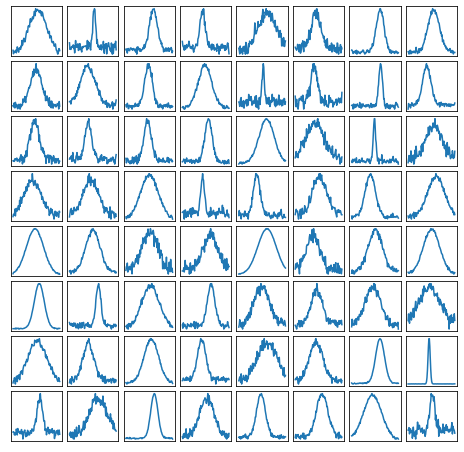

In [4]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x[0], y[0, 0])

Our goal is to find the real/physical descriptor of the data set in an unsupervised fashion, while ignoring (or separating) relative positions of the peaks. First, let's do a regular PCA decomposition:

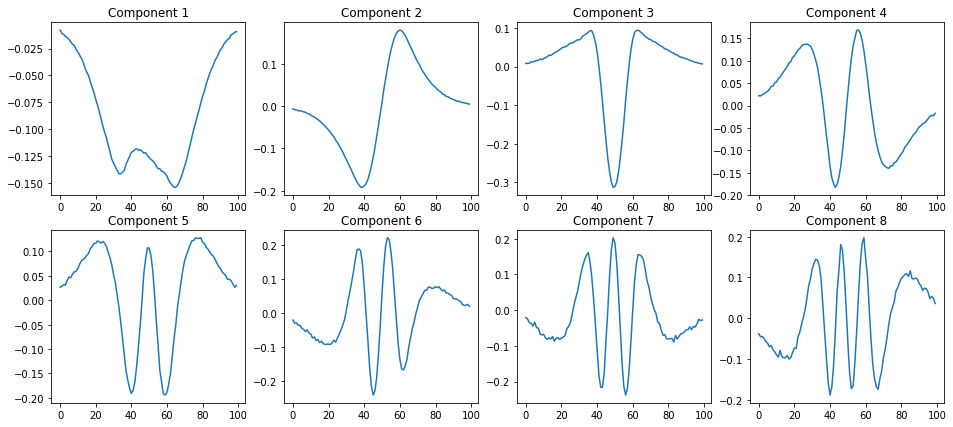

In [5]:
# Number of PCA components
nc = 8
# PCA decomposition
clf = decomposition.PCA(n_components=nc, random_state=42)
data_dec = clf.fit_transform(train_data)
components = clf.components_
# Plot
rows = int(torch.ceil(torch.tensor(nc)/5))
cols = int(torch.ceil(torch.tensor(nc)/rows))
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 3.5*(1+rows)//1.5))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    j = 0
    ax1.plot(components[i])
    ax1.set_title('Component ' + str(i + 1))
plt.show();

Obviously, it didn't work very well.... Now, let's train a regular VAE:

In [6]:
# Data dimensions
in_dim = (100,)

# Initialize vanilla VAE
vae = pv.models.trVAE(in_dim, latent_dim=2, coord=0, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for _ in range(250):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 62.3838
Epoch: 2 Training loss: 61.4413
Epoch: 3 Training loss: 61.0156
Epoch: 4 Training loss: 60.6906
Epoch: 5 Training loss: 60.2719
Epoch: 6 Training loss: 60.2010
Epoch: 7 Training loss: 60.1750
Epoch: 8 Training loss: 60.2027
Epoch: 9 Training loss: 60.1302
Epoch: 10 Training loss: 60.1206
Epoch: 11 Training loss: 60.1254
Epoch: 12 Training loss: 60.1178
Epoch: 13 Training loss: 60.1202
Epoch: 14 Training loss: 60.1084
Epoch: 15 Training loss: 60.1635
Epoch: 16 Training loss: 60.1056
Epoch: 17 Training loss: 60.1024
Epoch: 18 Training loss: 60.1000
Epoch: 19 Training loss: 60.0854
Epoch: 20 Training loss: 60.0859
Epoch: 21 Training loss: 60.1164
Epoch: 22 Training loss: 60.1581
Epoch: 23 Training loss: 60.0957
Epoch: 24 Training loss: 60.0898
Epoch: 25 Training loss: 60.0835
Epoch: 26 Training loss: 60.0731
Epoch: 27 Training loss: 60.1002
Epoch: 28 Training loss: 60.0636
Epoch: 29 Training loss: 60.0784
Epoch: 30 Training loss: 60.0684
Epoch: 31 Training 

Encode the training data into the latent space:

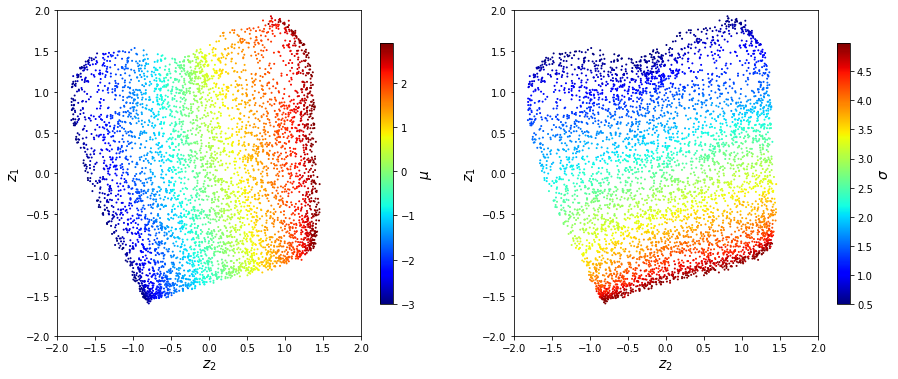

In [7]:
z_mean, z_sd = vae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu, cmap='jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig, cmap='jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2);

Plot the learned latent manifold:

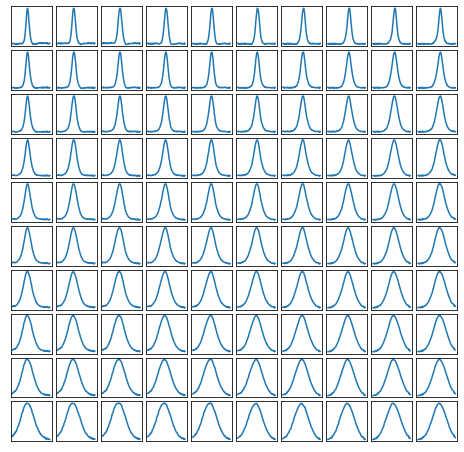

In [8]:
vae.manifold2d(d=10);

The results are not that bad! We can see that one of the latent variables is (mostly) associated with peak shifts and another one is (mostly) associated with changes in width. Now let's plot our latent variables versus the ground truth data (i.e., actual peak shift and changes in width):

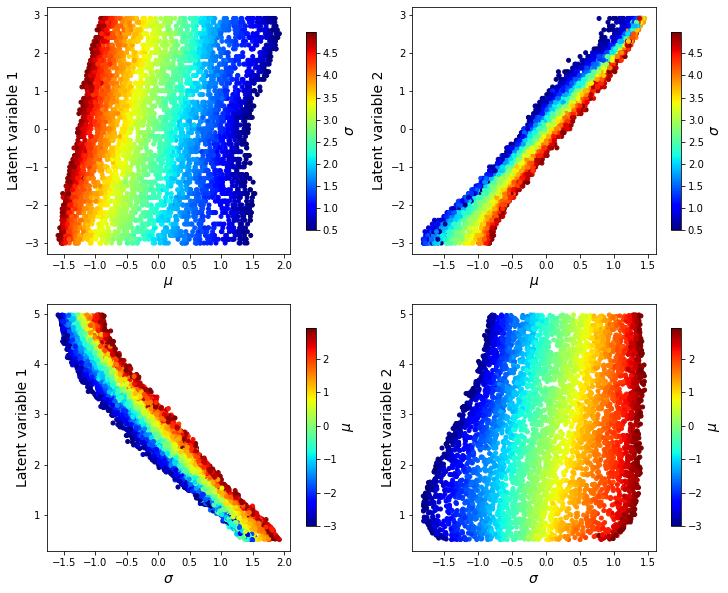

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

im00 = ax[0, 0].scatter(z_mean[:, 0], mu, c=sig, s=16, cmap='jet')
cbar00 = fig.colorbar(im00, ax=ax[0,0], shrink=.8)
cbar00.set_label("$\sigma$", fontsize=14)
ax[0, 0].set_xlabel("$\mu$", fontsize=14)
ax[0, 0].set_ylabel("Latent variable 1", fontsize=14)

im01 = ax[0, 1].scatter(z_mean[:, 1], mu, c=sig, s=16, cmap='jet')
cbar01 = fig.colorbar(im01, ax=ax[0,1], shrink=.8)
cbar01.set_label("$\sigma$", fontsize=14)
ax[0, 1].set_xlabel("$\mu$", fontsize=14)
ax[0, 1].set_ylabel("Latent variable 2", fontsize=14)

im10 = ax[1, 0].scatter(z_mean[:, 0], sig, c=mu, s=16, cmap='jet')
cbar10 = fig.colorbar(im10, ax=ax[1,0], shrink=.8)
cbar10.set_label("$\mu$", fontsize=14)
ax[1, 0].set_xlabel("$\sigma$", fontsize=14)
ax[1, 0].set_ylabel("Latent variable 1", fontsize=14)

im11 = ax[1, 1].scatter(z_mean[:, 1], sig, c=mu, s=16, cmap='jet')
cbar11 = fig.colorbar(im11, ax=ax[1,1], shrink=.8)
cbar11.set_label("$\mu$", fontsize=14)
ax[1, 1].set_xlabel("$\sigma$", fontsize=14)
ax[1, 1].set_ylabel("Latent variable 2", fontsize=14);

We can see that while there is definitely a relationship between ground truth variables and the encoded latent variables, they are not equal (even after if we do a "rescaling").

Now let's see if a shift-invariant VAE model can do better. In the shift-VAE, we have one latent variable designated to absorb the information about shifts, whereas the remaining latent variables encode the remaining factors of variation.

Let's initialize and train the shift-VAE model:

In [10]:
in_dim = (100,)

# Initialize shift-invariant VAE (to do this we change coord=0 to coord=1)
svae = pv.models.trVAE(in_dim, latent_dim=2, coord=1, dx_prior=.3)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(svae)

# Train for n epochs:
for _ in range(250):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 65.3020
Epoch: 2 Training loss: 62.0224
Epoch: 3 Training loss: 61.0132
Epoch: 4 Training loss: 60.8314
Epoch: 5 Training loss: 60.7623
Epoch: 6 Training loss: 60.6708
Epoch: 7 Training loss: 60.7209
Epoch: 8 Training loss: 60.6305
Epoch: 9 Training loss: 60.6099
Epoch: 10 Training loss: 60.6272
Epoch: 11 Training loss: 60.6018
Epoch: 12 Training loss: 60.5850
Epoch: 13 Training loss: 60.5783
Epoch: 14 Training loss: 60.5541
Epoch: 15 Training loss: 60.5518
Epoch: 16 Training loss: 60.5415
Epoch: 17 Training loss: 60.5541
Epoch: 18 Training loss: 60.5367
Epoch: 19 Training loss: 60.5627
Epoch: 20 Training loss: 60.5249
Epoch: 21 Training loss: 60.5181
Epoch: 22 Training loss: 60.5405
Epoch: 23 Training loss: 60.5080
Epoch: 24 Training loss: 60.5073
Epoch: 25 Training loss: 60.5333
Epoch: 26 Training loss: 60.5230
Epoch: 27 Training loss: 60.5373
Epoch: 28 Training loss: 60.5371
Epoch: 29 Training loss: 60.5046
Epoch: 30 Training loss: 60.4863
Epoch: 31 Training 

Encode train data into the latent space:

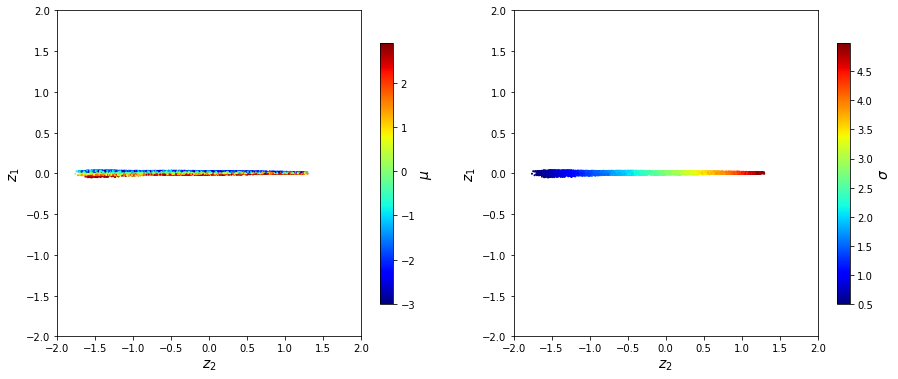

In [14]:
z_mean, z_sd = svae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu, cmap='jet')
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig, cmap='jet')
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2);

Note that the latent space is clearly collapsed, with the data points forming an 1D manifold (although there is a tiny "leakage" from the offset latent variable to the first ("collapsed") latent variable). Classically in VAEs, this collapse of latent space is perceived as a problem calling for the adjustment of the "loss" function. However, here we know that our ground truth data set has only two factors of variability, one of which is position. Hence, the dimensionality of our latent space hints at the true physical dimensionality of the data!

Now let's plot the learned latent manifold of the shift-VAE:

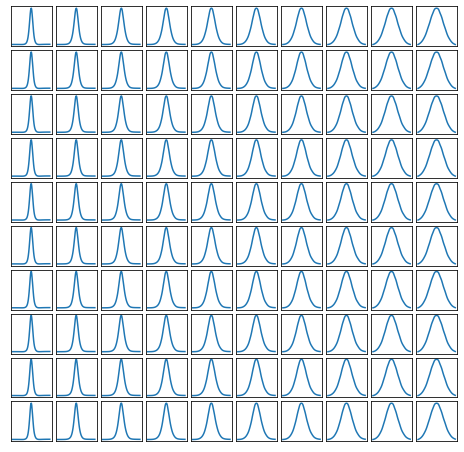

In [12]:
svae.manifold2d(d=10);

As mentioned above, the information about shifts is now encoded in the first latent variables so let's plot it against the real shift:

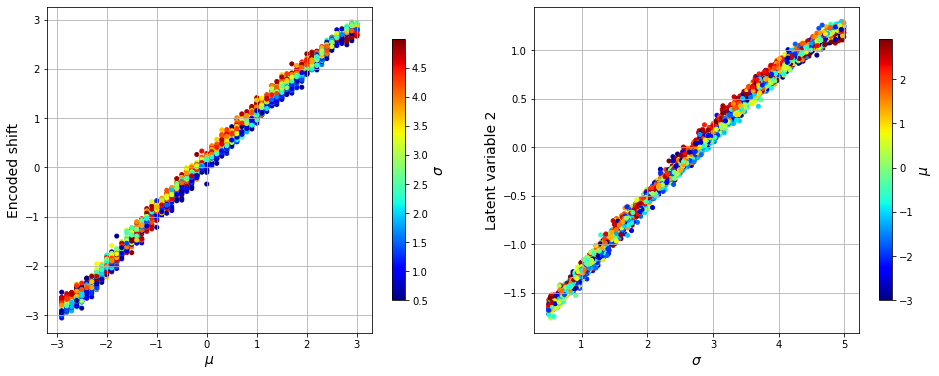

In [15]:
rescale = ((x.max() - x.min()) / 2 ) * svae.t_prior.cpu() # rescaling coefficient for shift latent variable
i = 2 # non-collapsed latent variable 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
im1 = ax1.scatter(-mu, z_mean[:, 0] * rescale, c=sig, cmap='jet', s=16)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\sigma$", fontsize=14)
ax1.set_xlabel("$\mu$", fontsize=14)
ax1.set_ylabel("Encoded shift", fontsize=14)
ax1.grid()

im2 = ax2.scatter(sig, z_mean[:, i], c=mu, cmap='jet', s=16)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\mu$", fontsize=14)
ax2.set_xlabel("$\sigma$", fontsize=14)
ax2.set_ylabel("Latent variable {}".format(i), fontsize=14)
ax2.grid()

Looks pretty good! We see mostly linear relationships and a big improvement compared to standard VAE. You may try playing with a KL scale factor and/or parameters of the encoder and decoder neural networks to get a further improvememnt.